# The Forage Virtual Experience: British Airways Data Science Task 1
### 15/04/2023

Exploring customer reviews from a reviews website. Doing sentiment analysis, topic modeling, and word cloud. You can do more if you want.

In [1]:
# !pip install wordcloud
# !pip install textblob
# !pip install gensim
# !pip install -U pyLDAvis
# !pip show pyLDAvis
# !pip show sklearn
# !pip install -U scikit-learn
# !pip uninstall sklearn
# !pip show scikit-learn
# !pip install -U numpy
# !pip show numpy

In [2]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import re
from PIL import Image
import seaborn as sns
from nltk.corpus import stopwords
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from nltk import FreqDist
from nltk.util import ngrams
import nltk
import string
from nltk.stem import WordNetLemmatizer
from matplotlib.ticker import MaxNLocator
from sklearn.decomposition import LatentDirichletAllocation as LDA
from nltk.stem.snowball import SnowballStemmer
import gensim
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from gensim.models.ldamodel import LdaModel
import gensim.corpora as corpora
from gensim.corpora import MmCorpus
from pprint import pprint
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

C:\Users\Nugroho Budianggoro\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
## Read data
df = pd.read_csv("BA_reviews.csv")
# df.head(3)

In [4]:
df_copy = df.copy()

In [5]:
# df.sample(5)

In [6]:
df["reviews"][1]

'Not Verified |  This is the worst airline. Not one thing went right. I don’t understand how they have got it so bad. Late take off, no gate when we arrived. Bags took over 40 minutes to arrive. Horrendous'

### Data Cleaning

In [7]:
## Drop unused column

df = df.drop(columns="Unnamed: 0")
df.head(3)

,reviews
0,✅ Trip Verified | Absolutely horrible experie...
1,Not Verified | This is the worst airline. Not...
2,✅ Trip Verified | I will never fly British Ai...


In [8]:
## Separate text

temp = df["reviews"].str.split("|", n=1, expand=True)

In [9]:
## Remove white spaces from the first column and give the separated texts separate column

df["reviews"] = temp[1].str.strip()
df["verified"] = temp[0]
df.head(3)

,reviews,verified
0,Absolutely horrible experience. I booked a tic...,✅ Trip Verified
1,This is the worst airline. Not one thing went ...,Not Verified
2,I will never fly British Airways again. To sta...,✅ Trip Verified


In [10]:
df.dtypes

reviews     object
verified    object
dtype: object

In [11]:
## Check for null values

df.isnull().sum()

reviews     0
verified    0
dtype: int64

In [12]:
## Remove emojis from the "verified" column

df["verified"] = df["verified"].apply(lambda x: x.encode("ascii", "ignore").decode("ascii"))
df.head(3)

,reviews,verified
0,Absolutely horrible experience. I booked a tic...,Trip Verified
1,This is the worst airline. Not one thing went ...,Not Verified
2,I will never fly British Airways again. To sta...,Trip Verified


In [13]:
## Remove white spaces in the "verified" column

df["verified"] = df["verified"].str.strip()

In [14]:
## Make the reviews become lowercase

df['reviews_clean'] = df['reviews'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df.head(3)

,reviews,verified,reviews_clean
0,Absolutely horrible experience. I booked a tic...,Trip Verified,absolutely horrible experience. i booked a tic...
1,This is the worst airline. Not one thing went ...,Not Verified,this is the worst airline. not one thing went ...
2,I will never fly British Airways again. To sta...,Trip Verified,i will never fly british airways again. to sta...


In [15]:
## Remove punctuations

df['reviews_clean'] = df['reviews_clean'].str.replace('[^\w\s]', '', regex=True)
df.head()

<>:3: DeprecationWarning: invalid escape sequence \w
<>:3: DeprecationWarning: invalid escape sequence \w
C:\Users\NUGROH~1\AppData\Local\Temp/ipykernel_12840/385364127.py:3: DeprecationWarning: invalid escape sequence \w
  df['reviews_clean'] = df['reviews_clean'].str.replace('[^\w\s]', '', regex=True)


,reviews,verified,reviews_clean
0,Absolutely horrible experience. I booked a tic...,Trip Verified,absolutely horrible experience i booked a tick...
1,This is the worst airline. Not one thing went ...,Not Verified,this is the worst airline not one thing went r...
2,I will never fly British Airways again. To sta...,Trip Verified,i will never fly british airways again to star...
3,Worst aircraft I have ever flown. The seats we...,Trip Verified,worst aircraft i have ever flown the seats wer...
4,I enjoyed my flight. The boarding was swift an...,Trip Verified,i enjoyed my flight the boarding was swift and...


In [16]:
## Remove stopwords

stopwords = stopwords.words('english')
df['reviews_clean'] = df['reviews_clean'].apply(lambda x: " ".join(x for x in x.split() if x not in stopwords))

df.head(3)

,reviews,verified,reviews_clean
0,Absolutely horrible experience. I booked a tic...,Trip Verified,absolutely horrible experience booked ticket e...
1,This is the worst airline. Not one thing went ...,Not Verified,worst airline one thing went right dont unders...
2,I will never fly British Airways again. To sta...,Trip Verified,never fly british airways start plane 2 hours ...


In [17]:
## Add custom stopwords

add_words = ['ba', 'one', 'us', 'back', 'could']

added_stopwords = set(stopwords).union(add_words)
df['reviews_clean'] = df['reviews_clean'].apply(lambda x: ' '.join(x for x in x.split() if x not in added_stopwords))

df.head()

,reviews,verified,reviews_clean
0,Absolutely horrible experience. I booked a tic...,Trip Verified,absolutely horrible experience booked ticket e...
1,This is the worst airline. Not one thing went ...,Not Verified,worst airline thing went right dont understand...
2,I will never fly British Airways again. To sta...,Trip Verified,never fly british airways start plane 2 hours ...
3,Worst aircraft I have ever flown. The seats we...,Trip Verified,worst aircraft ever flown seats cramped uncomf...
4,I enjoyed my flight. The boarding was swift an...,Trip Verified,enjoyed flight boarding swift service friendly...


In [18]:
## Remove URL

def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

df['reviews_clean'] = df['reviews_clean'].apply(lambda x: remove_url(x))

df.head()

,reviews,verified,reviews_clean
0,Absolutely horrible experience. I booked a tic...,Trip Verified,absolutely horrible experience booked ticket e...
1,This is the worst airline. Not one thing went ...,Not Verified,worst airline thing went right dont understand...
2,I will never fly British Airways again. To sta...,Trip Verified,never fly british airways start plane 2 hours ...
3,Worst aircraft I have ever flown. The seats we...,Trip Verified,worst aircraft ever flown seats cramped uncomf...
4,I enjoyed my flight. The boarding was swift an...,Trip Verified,enjoyed flight boarding swift service friendly...


In [19]:
## Correct spelling mistakes but I abort it because it is too long to finish

# df['reviews_clean'] = df['reviews_clean'].apply(lambda x: str(TextBlob(x).correct()))
# df.head()

In [20]:
lemmatizer = WordNetLemmatizer()
df['reviews_clean'] = df['reviews_clean'].apply(lambda x: lemmatizer.lemmatize(x))

df.head()

,reviews,verified,reviews_clean
0,Absolutely horrible experience. I booked a tic...,Trip Verified,absolutely horrible experience booked ticket e...
1,This is the worst airline. Not one thing went ...,Not Verified,worst airline thing went right dont understand...
2,I will never fly British Airways again. To sta...,Trip Verified,never fly british airways start plane 2 hours ...
3,Worst aircraft I have ever flown. The seats we...,Trip Verified,worst aircraft ever flown seats cramped uncomf...
4,I enjoyed my flight. The boarding was swift an...,Trip Verified,enjoyed flight boarding swift service friendly...


### Topic Modeling

In [21]:
## Topic modeling using scikit-learn

## Create function for stemming

stemmer = SnowballStemmer('english')

def tokenize_and_stem(sentence):
    tokens = nltk.word_tokenize(sentence)
    stems = [stemmer.stem(t) for t in tokens]
    return stems

def create_count_vectorizer(documents):
    count_vectorizer = CountVectorizer(tokenizer=tokenize_and_stem, max_features=1500)
    data = count_vectorizer.fit_transform(documents)
    return (count_vectorizer, data)


## Create function to create topic modeling algorithm

def create_and_fit_lda(data, n_topics):
    lda = LDA(n_components=n_topics, n_jobs=-1)
    lda.fit(data)
    return(lda)


def get_most_common_words_for_topics(model, vectorizer, n_top_words):
    words = vectorizer.get_feature_names_out()
    word_dict = {}
    for topic_index, topic in enumerate(model.components_):
        this_topic_words = [words[i] for i in topic.argsort()[:-n_top_words - 1: -1]]
        word_dict[topic_index] = this_topic_words
    return word_dict

def print_topic_words(word_dict):
    for key in word_dict.keys():
        print(f"Topic {key}")
        print('\t', word_dict[key])

In [22]:
## Topic modeling using gensim

def create_lda_model(id_dict, corpus, num_topics):
    lda_model = LdaModel(corpus=corpus,
                        id2word=id_dict,
                        num_topics=num_topics,
                        random_state=12,
                        chunksize=100,
                        passes=10)
    return lda_model

def get_topics(series, num_topics):
    series = series.apply(lambda x: simple_preprocess(x))
    texts = series.values
    id_dict = corpora.Dictionary(texts)
    corpus = [id_dict.doc2bow(text) for text in texts]
    lda_model = create_lda_model(id_dict, corpus, num_topics)
    pprint(lda_model.print_topics())
    
    return lda_model, corpus, id_dict

In [127]:
## Function to create data frame containing each reviews with their dominant topic

def format_topic_texts(ldamodel, corpus, texts):
    
    df_topic_texts = pd.DataFrame()
    
    for i, row in enumerate(ldamodel[corpus]):
        
        row = sorted(row, key = lambda x: (x[1]), reverse=True)
        
        for j, (topic_num, prop_topic) in enumerate(row):
            
            if j == 0:
                
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ', '.join([word for word, prop in wp])
                df_topic_texts = df_topic_texts.append(pd.Series([int(topic_num),
                                                      round(prop_topic, 4),
                                                      topic_keywords]),
                                                       ignore_index=True)
            else:
                break
    
    df_topic_texts.columns = ['dominant_topic',
                              'contribution_percentage',
                              'topic_keywords']
    
    contents = pd.Series(texts)
    df_topic_texts = pd.concat([df_topic_texts, contents], axis=1)
    
    return(df_topic_texts)

In [24]:
## Create function with coherence values to determine which number of topics is optimum

def compute_coherence_values(texts, start, limit, step):
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model, corpus, id_dict = get_topics(texts, num_topics)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=texts.str.split(), dictionary=id_dict, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    return model_list, coherence_values

In [195]:
## Create barplot to see how many reviews in each topic

def topic_barplot(topic_series):
    
    sns.set(rc={'figure.figsize':(10, 8)})
    
    title_var1 = ''
    
    if topic_series is topic_series_all:
        title_var1 = 'All'
        
    elif topic_series is topic_series_positive:
        title_var1 = 'Positive'
        
    elif topic_series is topic_series_negative:
        title_var1 = 'Negative'
        
    ax = sns.countplot(x = topic_series.astype(int))
    ax.set_title('Number of Reviews in Each Topic from ' + title_var1 + ' Reviews', fontdict={'size':18})
    ax.set(xlabel='Topic', ylabel='Count')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    for i in ax.containers:
        ax.bar_label(i, padding=3)

### Word Frequency

In [25]:
## Count one gram word frequencies

def word_frequency1(series, n):
    
    word_freq = pd.Series(' '.join(series).split()).value_counts()[:n]
        
    return word_freq

In [26]:
## This is needed for bigram processing

WNL = nltk.WordNetLemmatizer()

In [27]:
## Count bigram word frequencies

def word_frequency2(series, n):
    
    text = " ".join(review for review in series)
    tokens = nltk.word_tokenize(text)
    text1 = nltk.Text(tokens)

    text_content = [''.join(re.split("[ .,;:!?‘’``''@#$%^_&*()<>{}~\n\t\\\-]", word)) for word in text1]
    text_content = [WNL.lemmatize(t) for t in text_content]

#     nltk_tokens = nltk.word_tokenize(text)
    bigrams_list = list(nltk.bigrams(text_content))

    dictionary2 = [' '.join(tup) for tup in bigrams_list]
    vectorizer = CountVectorizer(ngram_range=(2, 2))

    bag_of_words = vectorizer.fit_transform(dictionary2)
    vectorizer.vocabulary_
    sum_words = bag_of_words.sum(axis=0)
    word_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    word_freq = sorted(word_freq, key = lambda x: x[1], reverse=True)
    
    freq, word = zip(*word_freq)
    
    result = pd.Series(word, freq)
    
    if n: result = result[:n]
    
    return result

<>:9: DeprecationWarning: invalid escape sequence \-
<>:9: DeprecationWarning: invalid escape sequence \-
C:\Users\NUGROH~1\AppData\Local\Temp/ipykernel_12840/1647528990.py:9: DeprecationWarning: invalid escape sequence \-
  text_content = [''.join(re.split("[ .,;:!?‘’``''@#$%^_&*()<>{}~\n\t\\\-]", word)) for word in text1]


In [28]:
## Get word frequency percentage

def freq_percentage(series):
    df_result = pd.DataFrame(series.reset_index())
    df_result.columns = ['word', 'frequency']
#     df_result['frequency'] = df_result['frequency'].astype(float)
    df_result['frequency_percentage'] = ((df_result['frequency'] / df_result['frequency'].sum()) * 100).astype(int)
    
    return df_result

### Word Cloud

In [29]:
## Word cloud for 1-grams

def wordcloud1(series):

    review_words = ""


    for review in series:

        review = str(review)

        tokens = review.split()

        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()

        review_words += " ".join(tokens)+" "

    wordcloud = WordCloud(width=2000,
                          height=2000,
                          background_color='black',
                          colormap='Set3',
                          min_font_size=10).generate(review_words)

    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()


In [30]:
## Word cloud for bigrams

def wordcloud2(series):
        
    text = " ".join(review for review in series)
    tokens = nltk.word_tokenize(text)
    text1 = nltk.Text(tokens)

    text_content = [''.join(re.split("[ .,;:!?‘’``''@#$%^_&*()<>{}~\n\t\\\-]", word)) for word in text1]
    text_content = [WNL.lemmatize(t) for t in text_content]

#     nltk_tokens = nltk.word_tokenize(text)
    bigrams_list = list(nltk.bigrams(text_content))

    dictionary2 = [' '.join(tup) for tup in bigrams_list]
    vectorizer = CountVectorizer(ngram_range=(2, 2))

    bag_of_words = vectorizer.fit_transform(dictionary2)
    vectorizer.vocabulary_
    sum_words = bag_of_words.sum(axis=0)
    word_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    word_freq = sorted(word_freq, key = lambda x: x[1], reverse=True)
    
    words_dict = dict(word_freq)

    wc_height = 2000
    wc_width = 2000
    wc_max_words = 200
    wordcloud = WordCloud(max_words=wc_max_words, height=wc_height, colormap='Set3', width=wc_width, background_color='black')
    wordcloud.generate_from_frequencies(words_dict)

    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

<>:9: DeprecationWarning: invalid escape sequence \-
<>:9: DeprecationWarning: invalid escape sequence \-
C:\Users\NUGROH~1\AppData\Local\Temp/ipykernel_12840/276796524.py:9: DeprecationWarning: invalid escape sequence \-
  text_content = [''.join(re.split("[ .,;:!?‘’``''@#$%^_&*()<>{}~\n\t\\\-]", word)) for word in text1]


### Sentiment Analysis

In [31]:
df['reviews_clean'] = df['reviews_clean'].astype(str)

polarity = lambda x: TextBlob(x).sentiment.polarity
subjectivity = lambda x: TextBlob(x).sentiment.subjectivity

df['polarity'] = df['reviews_clean'].apply(polarity)
df['subjectivity'] = df['reviews_clean'].apply(subjectivity)

df.head()
     

,reviews,verified,reviews_clean,polarity,subjectivity
0,Absolutely horrible experience. I booked a tic...,Trip Verified,absolutely horrible experience booked ticket e...,-0.196154,0.510897
1,This is the worst airline. Not one thing went ...,Not Verified,worst airline thing went right dont understand...,-0.428571,0.700595
2,I will never fly British Airways again. To sta...,Trip Verified,never fly british airways start plane 2 hours ...,-0.080556,0.561905
3,Worst aircraft I have ever flown. The seats we...,Trip Verified,worst aircraft ever flown seats cramped uncomf...,-0.181944,0.677778
4,I enjoyed my flight. The boarding was swift an...,Trip Verified,enjoyed flight boarding swift service friendly...,0.275000,0.494444


### Word Frequency Bar Plot

In [32]:
def word_freq_barplot(series, gram, n_words):
    
    sns.set(rc={'figure.figsize':(10, 8)})
    
    title_var1 = ''
    title_var2 = ''
    
    if series is series_all:
        title_var1 = 'All'
        
    elif series is series_positive:
        title_var1 = 'Positive'
        
    elif series is series_negative:
        title_var1 = 'Negative'
        
    if (gram == 1):
        title_var2 = 'Unigram'
    elif (gram == 2):
        title_var2 = 'Bigram'

    ## One gram word frequency

    if (gram == 1):
    
        df_temp = freq_percentage(word_frequency1(series, n_words))

        ax = sns.barplot(data = df_temp, x = 'frequency_percentage', y = 'word')

    ## Two gram word frequency

    elif (gram == 2):
        
        df_temp = freq_percentage(word_frequency2(series, n_words))

        ax = sns.barplot(data = df_temp, x = 'frequency_percentage', y = 'word')
        
    ax.set_title(title_var2 + ' Frequency Percentage in ' + title_var1 + ' Reviews', fontdict={'size':18})
    ax.set(xlabel='Percentage', ylabel=title_var2)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    for i in ax.containers:
        ax.bar_label(i, padding=3)    

In [ ]:
## Check composition of "Trip Verified" vs "Not Verified"

print('Unique values of "verified": ' + str(df["verified"].unique()))

print("Number of \"Trip Verified\" reviews: " + str(len(df[df["verified"] == "Trip Verified"])))
print("Number of \"Not Verified\" reviews: " + str(len(df[df["verified"] == "Not Verified"])))
sns.set_theme(style='whitegrid')
sns.countplot(x=df['verified'])

C:\Users\Nugroho Budianggoro\anaconda3\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\Nugroho Budianggoro\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


<AxesSubplot:xlabel='polarity', ylabel='Count'>

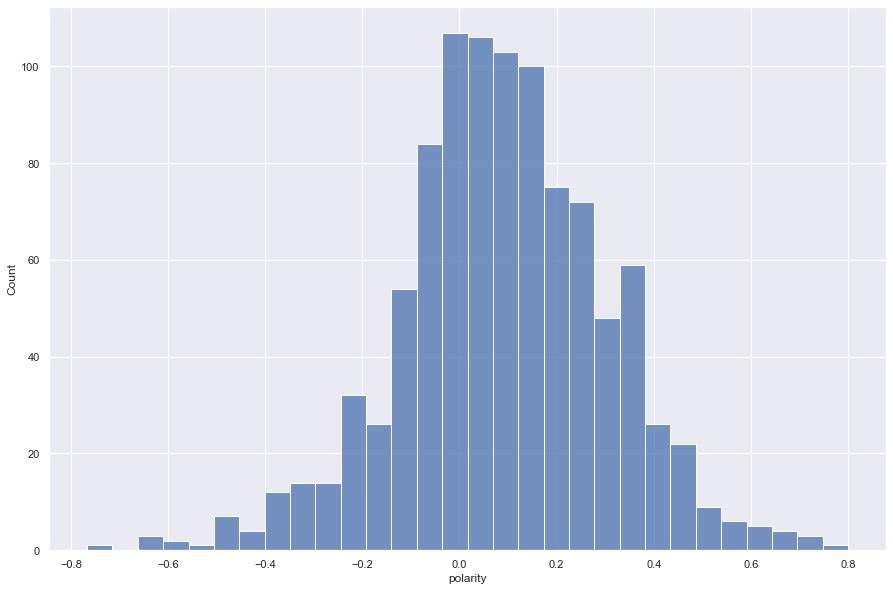

In [33]:
sns.set(rc={'figure.figsize':(15, 10)})

sns.histplot(data=df, x='polarity')

In [34]:
## Create polarity class to classify review sentiments

polarity_labels = ['negative', 'positive']
# df['polarity_class'] = pd.qcut(df['polarity'], q=[0, 0.5, 1], labels=polarity_labels)
df['polarity_class'] = pd.cut(df['polarity'], [-1, 0, 1], labels=polarity_labels)
df.head()

,reviews,verified,reviews_clean,polarity,subjectivity,polarity_class
0,Absolutely horrible experience. I booked a tic...,Trip Verified,absolutely horrible experience booked ticket e...,-0.196154,0.510897,negative
1,This is the worst airline. Not one thing went ...,Not Verified,worst airline thing went right dont understand...,-0.428571,0.700595,negative
2,I will never fly British Airways again. To sta...,Trip Verified,never fly british airways start plane 2 hours ...,-0.080556,0.561905,negative
3,Worst aircraft I have ever flown. The seats we...,Trip Verified,worst aircraft ever flown seats cramped uncomf...,-0.181944,0.677778,negative
4,I enjoyed my flight. The boarding was swift an...,Trip Verified,enjoyed flight boarding swift service friendly...,0.275000,0.494444,positive


In [35]:
df.sample(5)

,reviews,verified,reviews_clean,polarity,subjectivity,polarity_class
880,New York to Budapest via London. The second fl...,Trip Verified,new york budapest via london second flight bit...,-0.019394,0.550909,negative
205,We arrived 3 and half hours before our flight ...,Trip Verified,arrived 3 half hours flight queues terrible ai...,-0.140741,0.774074,negative
33,Lost my case and took 6 weeks to locate it and...,Not Verified,lost case took 6 weeks locate still replied 8 ...,-0.111072,0.340443,negative
746,Chicago to London. Cancelled flights just a fe...,Trip Verified,chicago london cancelled flights hours left ho...,-0.029762,0.368452,negative
184,This a new route which BA introduced at the be...,Trip Verified,new route introduced beginning june several ye...,-0.067666,0.473172,negative


C:\Users\Nugroho Budianggoro\anaconda3\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\Nugroho Budianggoro\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


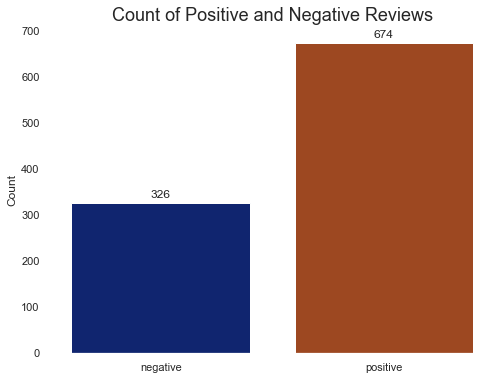

In [243]:
## See the proportion of the negative and positive reviews classes

sns.set(rc={'figure.figsize':(8, 6)})
sns.set_palette('dark')
ax = sns.countplot(x=df['polarity_class'])
ax.set_title('Count of Positive and Negative Reviews', fontdict={'size':18})
ax.set(xlabel='', ylabel='Count')
ax.set_facecolor('white')
for i in ax.containers: ax.bar_label(i, padding=3)

C:\Users\Nugroho Budianggoro\anaconda3\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\Nugroho Budianggoro\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


<AxesSubplot:xlabel='polarity', ylabel='Count'>

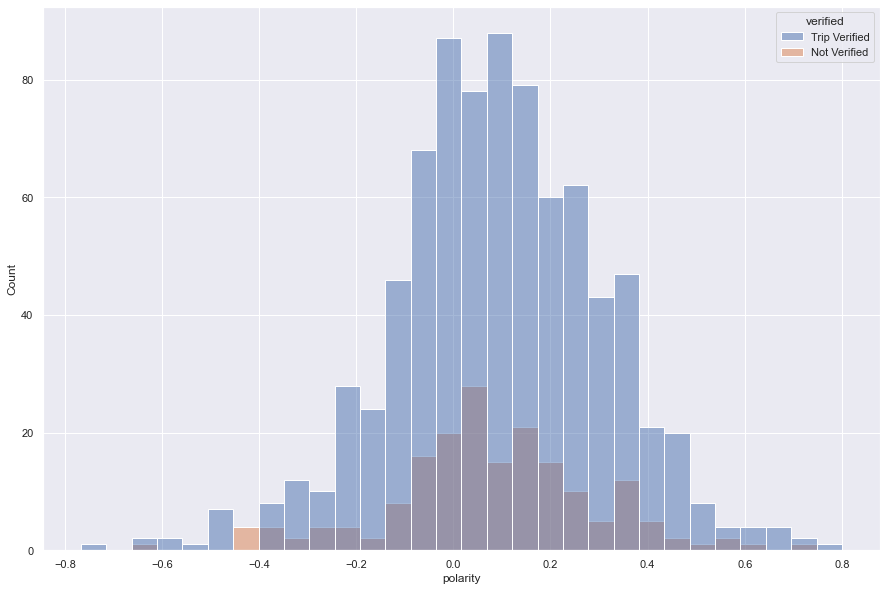

In [37]:
sns.set(rc={'figure.figsize':(15, 10)})

sns.histplot(data=df, x='polarity', hue='verified')

C:\Users\Nugroho Budianggoro\anaconda3\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\Nugroho Budianggoro\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


<AxesSubplot:xlabel='subjectivity', ylabel='Count'>

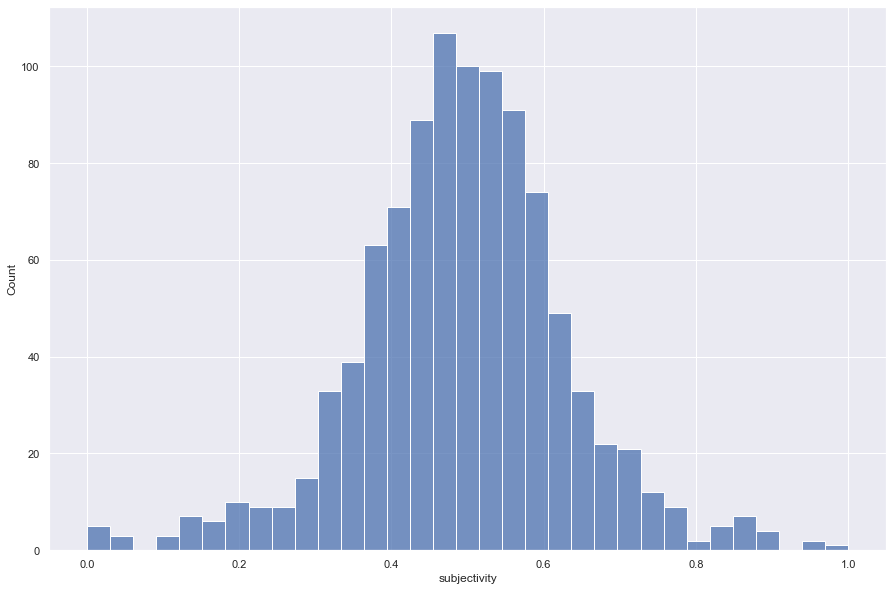

In [38]:
sns.set(rc={'figure.figsize':(15, 10)})

sns.histplot(data=df, x='subjectivity')

C:\Users\Nugroho Budianggoro\anaconda3\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\Nugroho Budianggoro\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


<AxesSubplot:xlabel='subjectivity', ylabel='Count'>

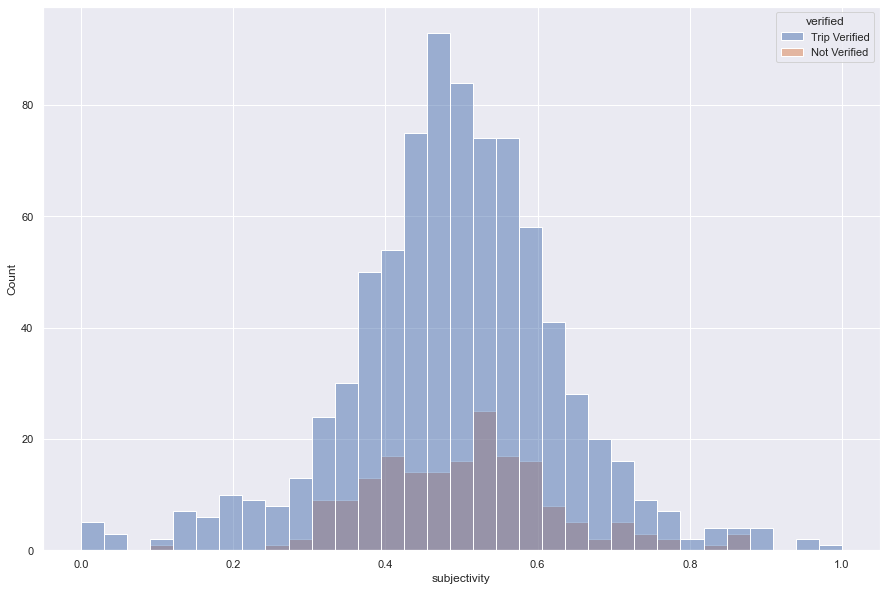

In [39]:
sns.set(rc={'figure.figsize':(15, 10)})

sns.histplot(data=df, x='subjectivity', hue='verified')

In [40]:
## Used to check complete reviews based on the the polarity class. It would take up space so no need to run it often.
# pd.set_option('display.max_colwidth', None)
# df[['reviews', 'polarity_class', 'polarity']].sample(30)

In [41]:
## Check the unique value of polarity class

df['polarity_class'].unique()

['negative', 'positive']
Categories (2, object): ['negative' < 'positive']

In [42]:
## Check for null values

df.isnull().sum()

reviews           0
verified          0
reviews_clean     0
polarity          0
subjectivity      0
polarity_class    0
dtype: int64

In [43]:
## Set the series for convenience

series_all = df['reviews_clean']

series_positive = df[df['polarity_class']=='positive']['reviews_clean']

series_negative = df[df['polarity_class']=='negative']['reviews_clean']

C:\Users\Nugroho Budianggoro\anaconda3\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\Nugroho Budianggoro\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


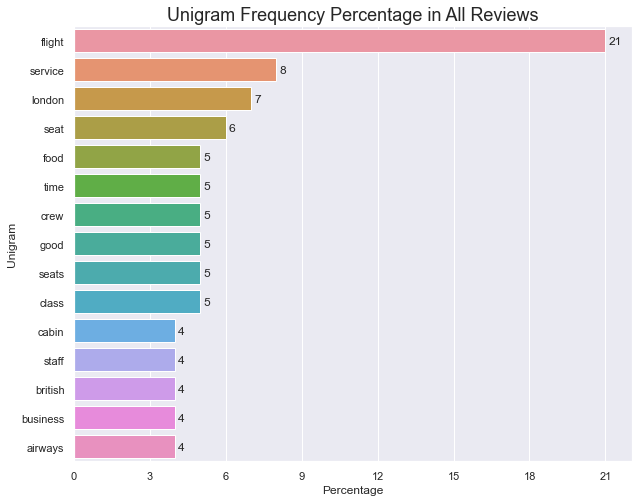

In [44]:
## One gram word frequency for all reviews

word_freq_barplot(series_all, 1, 15)  

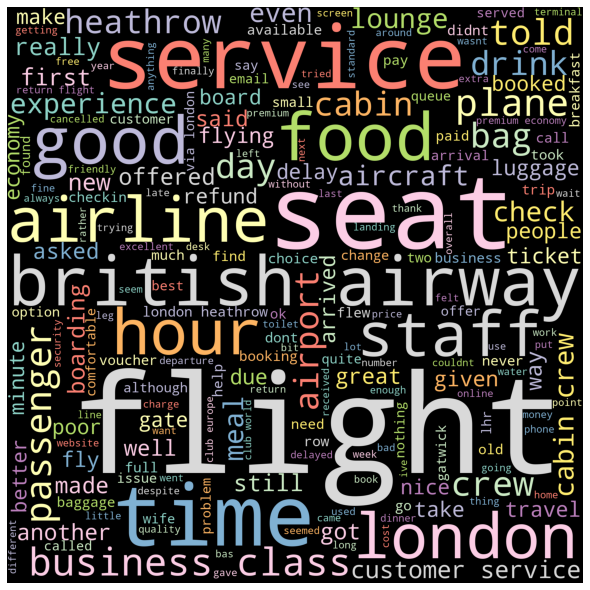

In [45]:
## One gram word cloud for all reviews

wordcloud1(series_all)

C:\Users\Nugroho Budianggoro\anaconda3\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\Nugroho Budianggoro\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


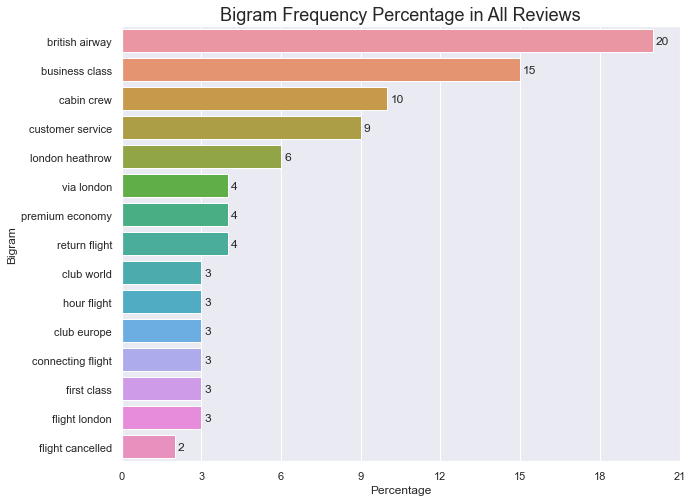

In [46]:
## Two gram word frequency for all reviews

word_freq_barplot(series_all, 2, 15)

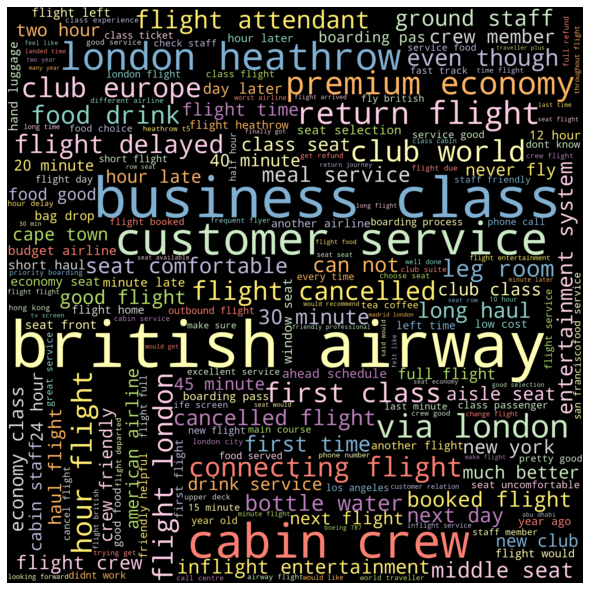

In [47]:
## 2-gram word cloud for all reviews

wordcloud2(series_all)

C:\Users\Nugroho Budianggoro\anaconda3\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\Nugroho Budianggoro\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


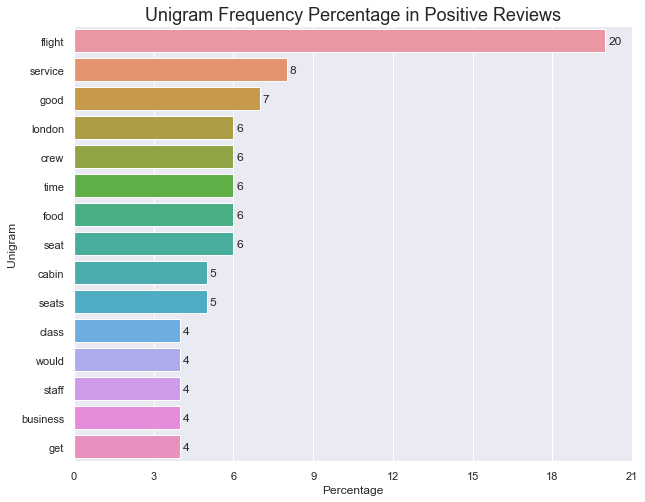

In [48]:
## One gram word frequency for positive reviews

word_freq_barplot(series_positive, 1, 15)
    

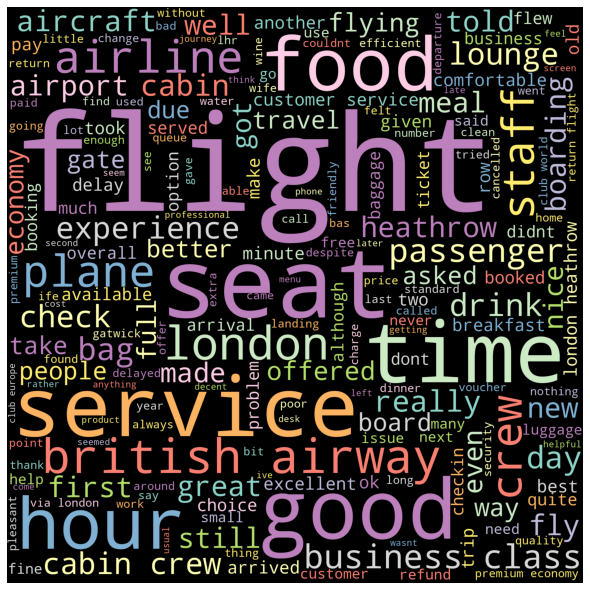

In [49]:
## One gram word cloud for the positive reviews

wordcloud1(series_positive)

C:\Users\Nugroho Budianggoro\anaconda3\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\Nugroho Budianggoro\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


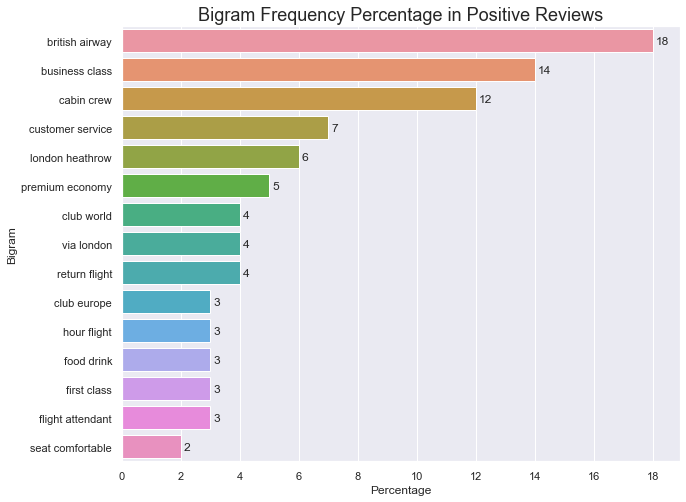

In [50]:
## Two gram word frequency for positive reviews

word_freq_barplot(series_positive, 2, 15)

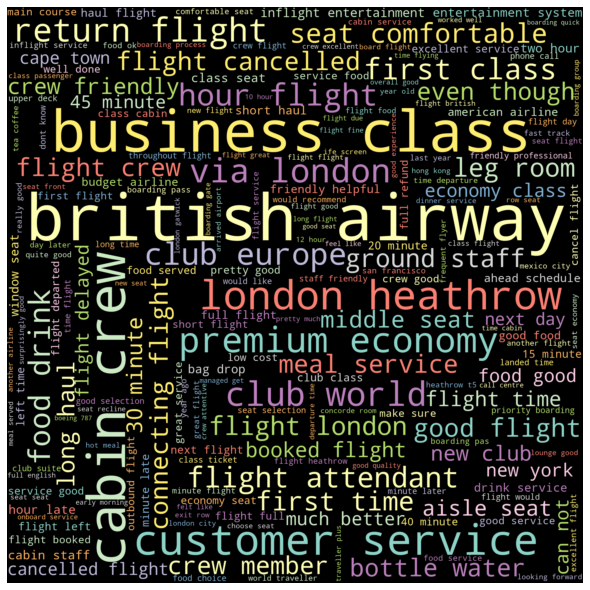

In [51]:
## 2-gram word cloud for the positive reviews

wordcloud2(series_positive)

C:\Users\Nugroho Budianggoro\anaconda3\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\Nugroho Budianggoro\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


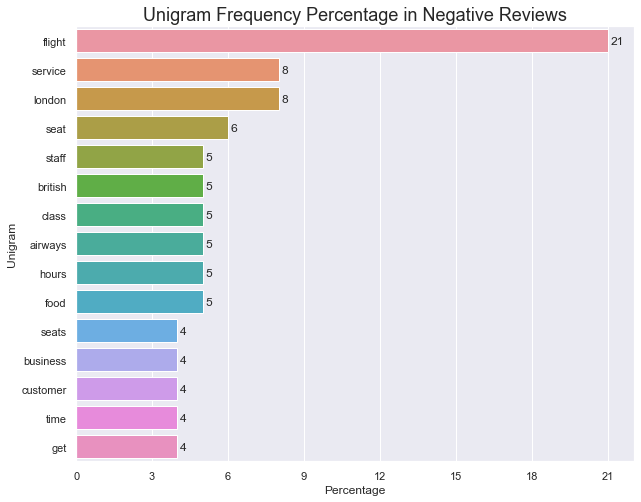

In [52]:
## One gram word frequency for negative reviews

word_freq_barplot(series_negative, 1, 15)

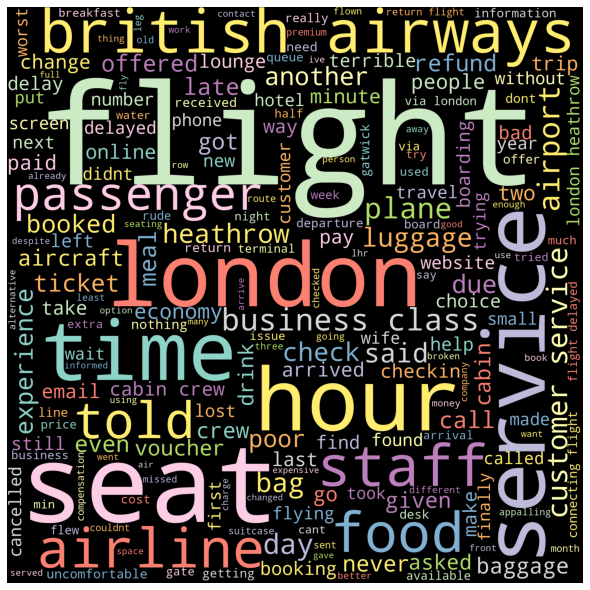

In [53]:
## One gram word cloud for the negative reviews

wordcloud1(series_negative)

C:\Users\Nugroho Budianggoro\anaconda3\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\Nugroho Budianggoro\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


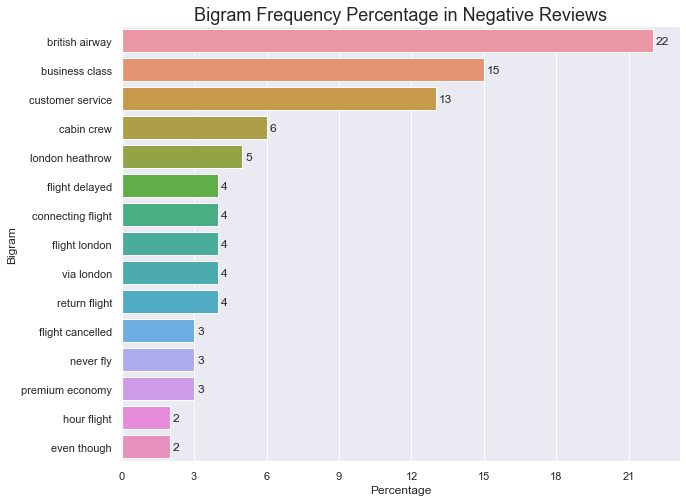

In [54]:
## Two gram word frequency for negative reviews

word_freq_barplot(series_negative, 2, 15)

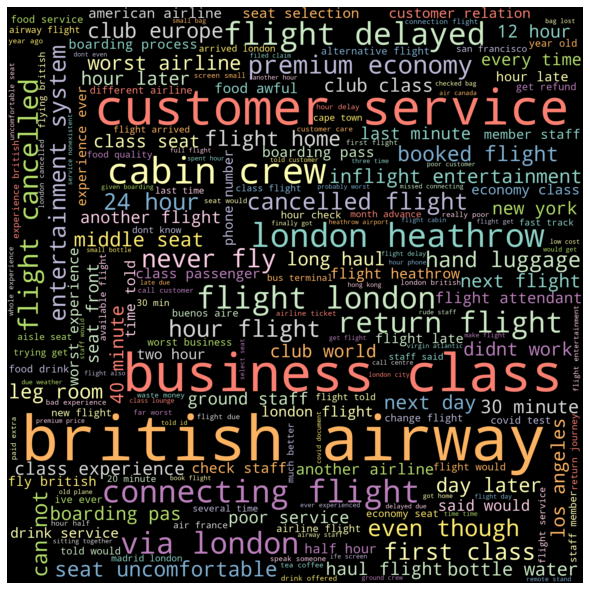

In [55]:
## 2-gram word cloud for the negative reviews

wordcloud2(series_negative)

In [56]:
## Create topic modeling words using scikit-learn. No need to run this as we are using the gensim version

# documents = df['reviews_clean']
# n_topics = 5

# (vectorizer, data) = create_count_vectorizer(documents)
# lda = create_and_fit_lda(data, n_topics)

## Print the topics and their top 

# topic_words = get_most_common_words_for_topics(lda, vectorizer, 10)
# print_topic_words(topic_words)

In [57]:
## Determne how many topics are most optimum. No need to run this often as it takes a long time

# model_list_all, coherence_values_all = compute_coherence_values(texts=series_all, limit=25, start=2, step=5) # the result of this was 18


# model_list_positive, coherence_values_positive = compute_coherence_values(texts=series_posiive, limit=25, start=2, step=5)

# model_list_negative, coherence_values_negative = compute_coherence_values(texts=series_negative, limit=25, start=2, step=5)

[(0,
  '0.019*"flight" + 0.011*"seat" + 0.011*"service" + 0.011*"food" + '
  '0.011*"crew" + 0.009*"cabin" + 0.009*"good" + 0.009*"seats" + '
  '0.009*"london" + 0.009*"class"'),
 (1,
  '0.024*"flight" + 0.010*"london" + 0.009*"british" + 0.009*"airways" + '
  '0.008*"customer" + 0.007*"would" + 0.007*"service" + 0.007*"told" + '
  '0.006*"hours" + 0.006*"get"')]
[(0,
  '0.020*"flight" + 0.016*"seat" + 0.015*"seats" + 0.013*"london" + '
  '0.013*"food" + 0.012*"service" + 0.009*"economy" + 0.008*"crew" + '
  '0.008*"cabin" + 0.007*"first"'),
 (1,
  '0.029*"flight" + 0.017*"staff" + 0.012*"plane" + 0.012*"bag" + '
  '0.011*"airport" + 0.010*"boarding" + 0.009*"hours" + 0.009*"check" + '
  '0.009*"minutes" + 0.008*"hour"'),
 (2,
  '0.026*"large" + 0.011*"appeared" + 0.009*"perfectly" + 0.009*"bin" + '
  '0.008*"pitch" + 0.006*"hall" + 0.005*"latest" + 0.005*"list" + 0.005*"test" '
  '+ 0.004*"discovered"'),
 (3,
  '0.048*"business" + 0.048*"class" + 0.015*"seats" + 0.014*"seat" + '
  '0.

In [63]:
limit = 25
start = 2
step = 5

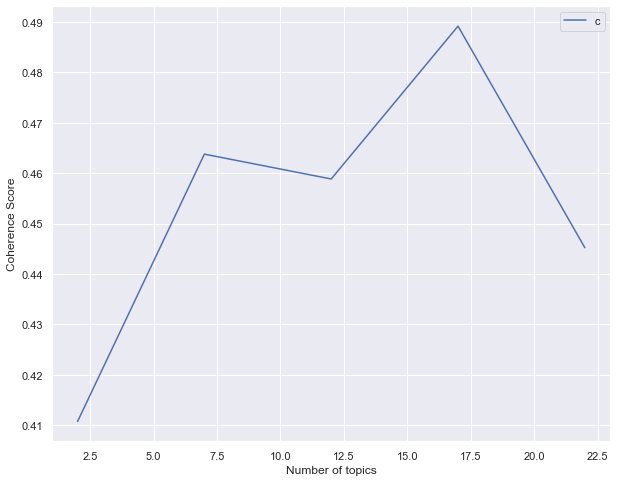

In [64]:
x = range(start, limit, step)
plt.plot(x, coherence_values_all)
plt.xlabel('Number of topics')
plt.ylabel('Coherence Score')
plt.legend (('coherence_values'), loc='best')
plt.show()

In [157]:
# lda, corpus, dictionary = get_topics(series_all, 18)

# lda_prepared = gensimvis.prepare(lda, corpus, dictionary)
# pyLDAvis.display(lda_prepared)

In [ ]:
## Using coherence score for all reviews topics is not so convenient usingn the largest number (18). So I use visual inspection instead.

In [153]:
# lda_all, corpus_all, dictionary_all = get_topics(series_all, 7)

# lda_prepared = gensimvis.prepare(lda_all, corpus_all, dictionary_all)
# pyLDAvis.display(lda_prepared)

In [154]:
# lda_all, corpus_all, dictionary_all = get_topics(series_all, 3)

# lda_prepared = gensimvis.prepare(lda_all, corpus_all, dictionary_all)
# pyLDAvis.display(lda_prepared)

In [155]:
# lda_all, corpus_all, dictionary_all = get_topics(series_all, 8)

# lda_prepared = gensimvis.prepare(lda_all, corpus_all, dictionary_all)
# pyLDAvis.display(lda_prepared)

In [156]:
# lda_all, corpus_all, dictionary_all = get_topics(series_all, 5)

# lda_prepared = gensimvis.prepare(lda_all, corpus_all, dictionary_all)
# pyLDAvis.display(lda_prepared)

In [152]:
lda_all, corpus_all, dictionary_all = get_topics(series_all, 4)

lda_prepared = gensimvis.prepare(lda_all, corpus_all, dictionary_all)
pyLDAvis.display(lda_prepared)

[(0,
  '0.021*"flight" + 0.012*"seat" + 0.012*"service" + 0.012*"food" + '
  '0.011*"crew" + 0.010*"cabin" + 0.010*"good" + 0.010*"london" + '
  '0.010*"seats" + 0.010*"class"'),
 (1,
  '0.028*"flight" + 0.011*"london" + 0.010*"british" + 0.010*"airways" + '
  '0.009*"customer" + 0.008*"would" + 0.008*"told" + 0.008*"service" + '
  '0.008*"hours" + 0.007*"get"'),
 (2,
  '0.009*"thank" + 0.005*"singapore" + 0.005*"points" + 0.005*"sit" + '
  '0.005*"attendant" + 0.004*"bring" + 0.004*"negative" + 0.003*"plastic" + '
  '0.003*"husband" + 0.003*"walk"'),
 (3,
  '0.009*"delayed" + 0.008*"american" + 0.006*"glasgow" + 0.006*"los" + '
  '0.006*"angeles" + 0.005*"connection" + 0.005*"connecting" + 0.005*"vegan" + '
  '0.005*"wish" + 0.004*"seattle"')]


In [149]:
lda_positive, corpus_positive, dictionary_positive = get_topics(series_positive, 5)

lda_prepared = gensimvis.prepare(lda_positive, corpus_positive, dictionary_positive)
pyLDAvis.display(lda_prepared)

[(0,
  '0.008*"toronto" + 0.006*"cheaper" + 0.005*"onboard" + 0.005*"sandwiches" + '
  '0.005*"update" + 0.005*"wish" + 0.004*"flown" + 0.004*"others" + '
  '0.004*"operate" + 0.004*"counter"'),
 (1,
  '0.029*"flight" + 0.010*"british" + 0.010*"london" + 0.010*"airways" + '
  '0.008*"would" + 0.008*"get" + 0.008*"hours" + 0.008*"service" + '
  '0.007*"told" + 0.007*"airline"'),
 (2,
  '0.026*"flight" + 0.018*"crew" + 0.015*"good" + 0.013*"service" + '
  '0.013*"food" + 0.013*"cabin" + 0.011*"time" + 0.011*"london" + '
  '0.008*"boarding" + 0.007*"well"'),
 (3,
  '0.007*"st" + 0.007*"travel" + 0.007*"refund" + 0.007*"many" + '
  '0.006*"customer" + 0.006*"voucher" + 0.006*"year" + 0.005*"vouchers" + '
  '0.005*"numbers" + 0.004*"months"'),
 (4,
  '0.024*"class" + 0.020*"business" + 0.020*"seats" + 0.019*"seat" + '
  '0.012*"economy" + 0.009*"food" + 0.008*"premium" + 0.008*"first" + '
  '0.007*"good" + 0.007*"service"')]


In [158]:
# lda_positive, corpus_positive, dictionary_positive = get_topics(series_positive, 4)

# lda_prepared = gensimvis.prepare(lda_positive, corpus_positive, dictionary_positive)
# pyLDAvis.display(lda_prepared)

In [159]:
# lda_positive, corpus_positive, dictionary_positive = get_topics(series_positive, 6)

# lda_prepared = gensimvis.prepare(lda_positive, corpus_positive, dictionary_positive)
# pyLDAvis.display(lda_prepared)

In [160]:
# lda_negative, corpus_negative, dictionary_negative = get_topics(series_negative, 5)

# lda_prepared = gensimvis.prepare(lda_negative, corpus_negative, dictionary_negative)
# pyLDAvis.display(lda_prepared)

In [148]:
lda_negative, corpus_negative, dictionary_negative = get_topics(series_negative, 4)

lda_prepared = gensimvis.prepare(lda_negative, corpus_negative, dictionary_negative)
pyLDAvis.display(lda_prepared)

[(0,
  '0.018*"seat" + 0.014*"service" + 0.014*"flight" + 0.011*"seats" + '
  '0.011*"food" + 0.009*"class" + 0.009*"cabin" + 0.009*"business" + '
  '0.008*"london" + 0.007*"crew"'),
 (1,
  '0.015*"vegan" + 0.012*"meals" + 0.008*"said" + 0.008*"service" + '
  '0.008*"customer" + 0.008*"milk" + 0.005*"staff" + 0.005*"london" + '
  '0.005*"appalling" + 0.005*"rome"'),
 (2,
  '0.013*"business" + 0.010*"class" + 0.005*"sit" + 0.005*"handled" + '
  '0.005*"first" + 0.005*"award" + 0.005*"york" + 0.004*"divider" + '
  '0.004*"london" + 0.004*"avios"'),
 (3,
  '0.033*"flight" + 0.015*"london" + 0.011*"airways" + 0.011*"british" + '
  '0.011*"service" + 0.009*"staff" + 0.008*"airport" + 0.008*"customer" + '
  '0.008*"heathrow" + 0.007*"hours"')]


### The topics and their keywords:


ALL (4 topics)

1.
flight seat service food crew cabin good london seats class 

2.
flight london british airways customer would told service hours get 

3.
thank singapore points sit attendant bring negative plastic husband walk 

4.
delayed american glasgow los angeles connection connecting vegan wish seattle  


POSITIVE (5 topics)

1.
toronto cheaper onboard sandwiches update wish flown others operate counter 

2.
flight british london airways would get hours service told airline 

3.
flight crew good service food cabin time london boarding well 

4.
st travel refund many customer voucher year vouchers numbers months 

5.
class business seats seat economy food premium first good service  


NEGATIVE (4 topics)

1.
seat service flight seats food class cabin business london crew  

2.
vegan meals said service customer milk staff london appalling rome  

3.
business class sit handled first award york divider london avios  

4.
flight london airways british service staff airport customer heathrow hours  




In [177]:
df_topic_texts_all = format_topic_texts(ldamodel=lda_all, corpus=corpus_all, texts=series_all.reset_index(drop=True))

df_topics_all = df_topic_texts_all.reset_index()
df_topics_all.columns = ['review',
                         'dominant_topic',
                         'percentage_topic_contribution',
                         'keywords',
                         'texts'
                        ]
df_topics_all['dominant_topic'] = df_topics_all['dominant_topic'] + 1

df_topics_all.head()

,review,dominant_topic,percentage_topic_contribution,keywords,texts
0,0,2.0,0.9395,"flight, london, british, airways, customer, wo...",absolutely horrible experience booked ticket e...
1,1,2.0,0.9595,"flight, london, british, airways, customer, wo...",worst airline thing went right dont understand...
2,2,1.0,0.6627,"flight, seat, service, food, crew, cabin, good...",never fly british airways start plane 2 hours ...
3,3,1.0,0.8658,"flight, seat, service, food, crew, cabin, good...",worst aircraft ever flown seats cramped uncomf...
4,4,1.0,0.9750,"flight, seat, service, food, crew, cabin, good...",enjoyed flight boarding swift service friendly...


In [176]:
df_topic_texts_positive = format_topic_texts(ldamodel=lda_positive, corpus=corpus_positive, texts=series_positive.reset_index(drop=True))

df_topics_positive = df_topic_texts_positive.reset_index()
df_topics_positive.columns = ['review',
                             'dominant_topic',
                             'percentage_topic_contribution',
                             'keywords',
                             'texts'
                            ]

df_topics_positive['dominant_topic'] = df_topics_positive['dominant_topic'] + 1

df_topics_positive.head()

,review,dominant_topic,percentage_topic_contribution,keywords,texts
0,0,3.0,0.9739,"flight, crew, good, service, food, cabin, time...",enjoyed flight boarding swift service friendly...
1,1,3.0,0.6152,"flight, crew, good, service, food, cabin, time...",make hard lounge experience staff taking care ...
2,2,2.0,0.9816,"flight, british, london, airways, would, get, ...",several delays canceled flights finally made c...
3,3,2.0,0.6898,"flight, british, london, airways, would, get, ...",swore would never fly messed much trying get b...
4,4,1.0,0.4105,"toronto, cheaper, onboard, sandwiches, update,...",flown many years time 10 years ago getting bet...


In [179]:
df_topic_texts_negative = format_topic_texts(ldamodel=lda_negative, corpus=corpus_negative, texts=series_negative.reset_index(drop=True))

df_topics_negative = df_topic_texts_negative.reset_index()
df_topics_negative.columns = ['review',
                             'dominant_topic',
                             'percentage_topic_contribution',
                             'keywords',
                             'texts'
                            ]
df_topics_negative['dominant_topic'] = df_topics_negative['dominant_topic'] + 1

df_topics_negative.head()

,review,dominant_topic,percentage_topic_contribution,keywords,texts
0,0,4.0,0.8202,"flight, london, airways, british, service, sta...",absolutely horrible experience booked ticket e...
1,1,4.0,0.9578,"flight, london, airways, british, service, sta...",worst airline thing went right dont understand...
2,2,1.0,0.6221,"seat, service, flight, seats, food, class, cab...",never fly british airways start plane 2 hours ...
3,3,1.0,0.7507,"seat, service, flight, seats, food, class, cab...",worst aircraft ever flown seats cramped uncomf...
4,4,1.0,0.9844,"seat, service, flight, seats, food, class, cab...",literally worst flight life booking tickets to...


In [ ]:
topic_series_all = df_topics_all['dominant_topic']
topic_series_positive = df_topics_positive['dominant_topic']
topic_series_negative = df_topics_negative['dominant_topic']

C:\Users\Nugroho Budianggoro\anaconda3\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\Nugroho Budianggoro\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


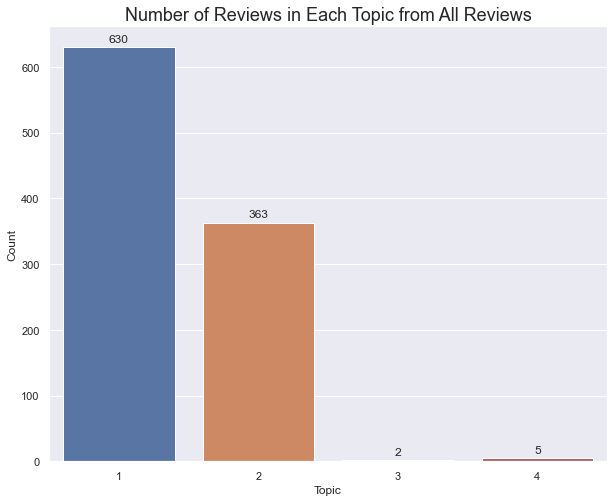

In [198]:
topic_barplot(topic_series_all)

C:\Users\Nugroho Budianggoro\anaconda3\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\Nugroho Budianggoro\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


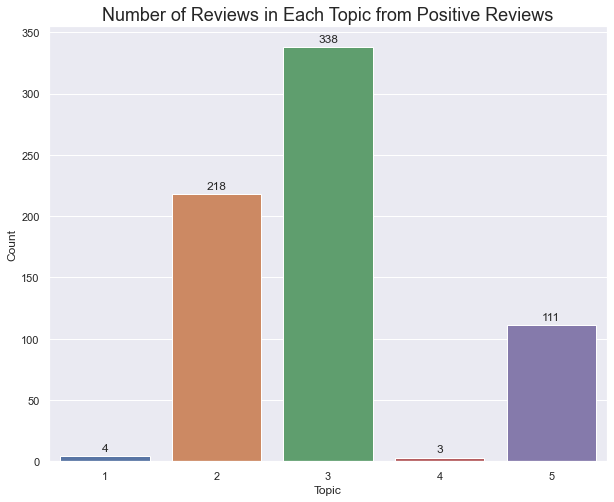

In [199]:
topic_barplot(topic_series_positive)

C:\Users\Nugroho Budianggoro\anaconda3\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\Nugroho Budianggoro\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


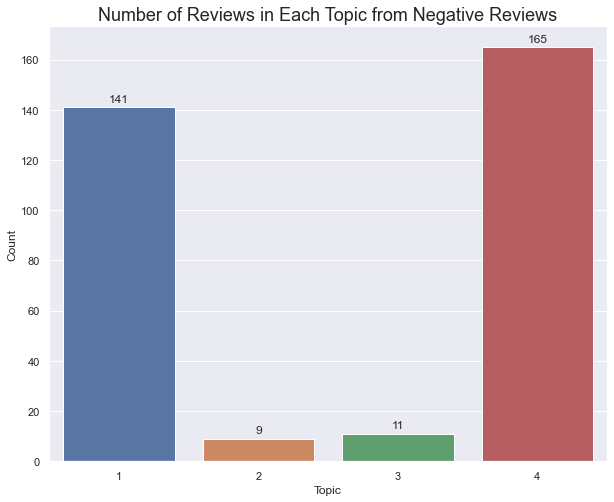

In [196]:
topic_barplot(topic_series_negative)

In [203]:
df_topics_sentiments_all = pd.merge(df, df_topics_all, left_index=True, right_index=True).drop(columns=['texts', 'review'])
df_topics_sentiments_all['dominant_topic'] = df_topics_sentiments_all['dominant_topic'].astype(int)
df_topics_sentiments_all.head()

,reviews,verified,reviews_clean,polarity,subjectivity,polarity_class,dominant_topic,percentage_topic_contribution,keywords
0,Absolutely horrible experience. I booked a tic...,Trip Verified,absolutely horrible experience booked ticket e...,-0.196154,0.510897,negative,2,0.9395,"flight, london, british, airways, customer, wo..."
1,This is the worst airline. Not one thing went ...,Not Verified,worst airline thing went right dont understand...,-0.428571,0.700595,negative,2,0.9595,"flight, london, british, airways, customer, wo..."
2,I will never fly British Airways again. To sta...,Trip Verified,never fly british airways start plane 2 hours ...,-0.080556,0.561905,negative,1,0.6627,"flight, seat, service, food, crew, cabin, good..."
3,Worst aircraft I have ever flown. The seats we...,Trip Verified,worst aircraft ever flown seats cramped uncomf...,-0.181944,0.677778,negative,1,0.8658,"flight, seat, service, food, crew, cabin, good..."
4,I enjoyed my flight. The boarding was swift an...,Trip Verified,enjoyed flight boarding swift service friendly...,0.275000,0.494444,positive,1,0.9750,"flight, seat, service, food, crew, cabin, good..."


C:\Users\Nugroho Budianggoro\anaconda3\lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\Users\Nugroho Budianggoro\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


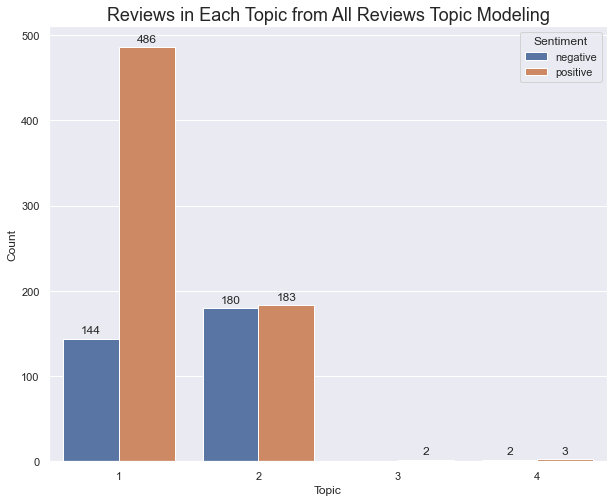

In [213]:
ax = sns.countplot(data=df_topics_sentiments_all, x='dominant_topic', hue='polarity_class')
ax.set_title('Reviews in Each Topic from All Reviews Topic Modeling', fontdict={'size':18})
ax.set(xlabel='Topic', ylabel='Count')
ax.legend_.set(title='Sentiment')
for i in ax.containers: ax.bar_label(i, padding=3)